## Задание
Разобраться с моделькой перевода как она устроена
запустить для перевода с русского на английский (при желании можно взять другие пары языков) два варианта с вниманием и без внимания
оценить качество насколько корректно переводит 

In [48]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [3]:
!wget http://www.manythings.org/anki/ita-eng.zip

--2023-07-26 16:38:35--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8011806 (7,6M) [application/zip]
Saving to: ‘ita-eng.zip’

ita-eng.zip         100%[===================>]   7,64M   150KB/s    in 2m 9s   

2023-07-26 16:40:45 (60,8 KB/s) - ‘ita-eng.zip’ saved [8011806/8011806]



In [4]:
#Создаем папку и извлекаем туда файлы из архива
!mkdir ita-eng
!unzip ita-eng.zip -d ita-eng/

Archive:  ita-eng.zip
  inflating: ita-eng/ita.txt         
  inflating: ita-eng/_about.txt      


In [7]:
!ls ./ita-eng/ -lah

total 50M
drwxrwxr-x 2 msi msi 4,0K июл 26 16:45 .
drwxrwxr-x 4 msi msi 4,0K июл 26 16:45 ..
-rw-r--r-- 1 msi msi 1,5K апр  2 03:16 _about.txt
-rw-r--r-- 1 msi msi  50M апр  2 03:16 ita.txt


In [8]:
# Загружаем файл
path_to_file = "./ita-eng/ita.txt"

In [9]:
#просмотр файла
f = open(path_to_file)
for line in f:
    print(line)
    break

Hi.	Ciao!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #607364 (Cero)



In [10]:
#функция препроцессинга
def preprocess_sentence(w):
  #переводим предложение к нижнему регистру и удалем начальные и конечные пробелы
    w = w.lower().strip()

  # отделяем пробелом слово и следующую за ним пунктуацию
  # пример: "he is a boy." => "he is a boy ."
    w = re.sub(r"([?.!,])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

  # все, кроме букв и знаков пунктуации, заменяем пробелом
    w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)
  
  #удаляем лишние пробелы в начале и конце
    w = w.strip()

  # создаем начало и конец последовательности
  # теперь модель знает, где начинать и заканчивать предсказания
    w = '<start> ' + w + ' <end>'
    return w

In [11]:
#пример работы препроцессинга
preprocess_sentence("I can't go.")


"<start> i can't go . <end>"

In [12]:
# 1. Убираем акценты
# 2. Очищаем предложения
# 3. Возвращаем пары слов: [ENG, RUS]
def create_dataset(path, num_examples):
  #считываем строки файла
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  #каждую строку разделяем на пробелы, берем первые 2 слова, препроцессим их и возвращаем пару
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [15]:
#пример работы
en, it = create_dataset(path_to_file, None)
print(en[0])
print(it[0])

<start> hi . <end>
<start> ciao ! <end>


In [16]:
# количество данных в датасете
len(en), len(it)

(364200, 364200)

In [17]:
def tokenize(lang):
      #токенизируем текст, отфильтвовываем пробелы
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
      #обновляем внутренний словарь на основе lang
    lang_tokenizer.fit_on_texts(lang)
      #преобразуем каждый элемент из lang в последовательность чисел
    tensor = lang_tokenizer.texts_to_sequences(lang)
      #преобразуем тензор в матрицу (кол-во тензоров * max-длина), 
      #при этом короткие последовательности заполняем нулями сзади, а длинные -- обрезаем сзади
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

In [18]:
def load_dataset(path, num_examples=None):
      # создаем очищенные анг (выходные), русские (входные) пары
    targ_lang, inp_lang = create_dataset(path, num_examples)
    #применяем токенизацию к каждому элементы из пары
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [19]:
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

input_tensor, target_tensor

(array([[   1, 1217,   40, ...,    0,    0,    0],
        [   1, 1217,    3, ...,    0,    0,    0],
        [   1, 3633,   40, ...,    0,    0,    0],
        ...,
        [   1,    4,   32, ...,    0,    0,    0],
        [   1,    4,   32, ...,    0,    0,    0],
        [   1,    4,   32, ...,    0,    0,    0]], dtype=int32),
 array([[   1, 1054,    3, ...,    0,    0,    0],
        [   1, 1054,    3, ...,    0,    0,    0],
        [   1,  346,   48, ...,    0,    0,    0],
        ...,
        [   1,    5,    8, ...,    0,    0,    0],
        [   1,    5,    8, ...,    0,    0,    0],
        [   1,    5,    8, ...,    0,    0,    0]], dtype=int32))

In [20]:
# Вычисляем максимальную длину тензоров
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
max_length_targ, max_length_inp

(11, 20)

In [21]:
# Создаем тренировочные и валидационные датасеты
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# размеры датасетов
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


In [22]:
#функция получения из токена текста (выводим токен и его индекс)
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [23]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
22 ----> noi
195 ----> eravamo
3330 ----> sedute
6095 ----> sull'erba
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
18 ----> we
525 ----> sat
77 ----> on
13 ----> the
2065 ----> grass
3 ----> .
2 ----> <end>


In [24]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
#количество эпох
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 300
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1
#из каждого элемента (input_tensor_train, target_tensor_train) создает тензор
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
#разбиваем датасет на батчи (списки по 64), удаляя последний неполный батч
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [25]:
example_input_batch, example_target_batch = next(iter(dataset))
print(example_input_batch.shape, example_target_batch.shape)
example_input_batch[0], example_target_batch[0]

(64, 20) (64, 11)


(<tf.Tensor: shape=(20,), dtype=int32, numpy=
 array([  1,   4, 354,  45,  22,   3,   2,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0], dtype=int32)>,
 <tf.Tensor: shape=(11,), dtype=int32, numpy=array([  1,   5, 320,  83,  70,   3,   2,   0,   0,   0,   0], dtype=int32)>)

In [26]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=False,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return state

    def initialize_hidden_state(self):
    #создаем тензор из нулей размера (батч, кол-во ячеек)
        return tf.zeros((self.batch_sz, self.enc_units))

In [27]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# инициализитеруем начальное скрытое состояние (из нулей)
sample_hidden = encoder.initialize_hidden_state()
# применяем энкодер к входному батчу и скрытому состоянию
sample_hidden = encoder(example_input_batch, sample_hidden)
# print ('Форма выхода энкодера: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder Hidden state shape: (batch size, units) (64, 1024)


In [28]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, x, hidden):
        # x shape после прохождения через эмбеддинг == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # отправляем в GRU входные данные и скрытое состояние (от энкодера)
        #выход GRU (batch_size, timesteps, units)
        #размер возвращаемого внутреннего состояния (batch_size, units)
        output, state = self.gru(x, initial_state=hidden)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # x shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state

In [29]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
#применяем декодер к случайному батчу из равномерного распределения (батч,1) и выходу энкодера
decoder_sample_x, decoder_sample_h = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden)
decoder_sample_x.shape, decoder_sample_h.shape

(TensorShape([64, 6470]), TensorShape([64, 1024]))

In [30]:
#оптимизатор
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

#функция потерь
def loss_function(real, pred):
      #делаем инверсию значений сравнения каждого из real с нулем (возвращается true или false)
    mask = tf.math.logical_not(tf.math.equal(real, 0))
      #применяем функцию ошибок к реальным данным и предсказанным
    loss_ = loss_object(real, pred)
      #приводим тензор mask к новому типу loss_.dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
      #умножаем loss_ на mask
    loss_ *= mask
      # возвращаем среднее значениe всех элементов
    return tf.reduce_mean(loss_)

In [31]:
checkpoint_dir = './training_nmt_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [32]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
  # перечисляем операции для автоматического дифференцирования
    with tf.GradientTape() as tape:
        #получаем выход encoder
        enc_hidden = encoder(inp, enc_hidden)
        #помещаем его в скрытое состояние decoder
        dec_hidden = enc_hidden
        #формируем вход декодера:
                 # берем список длины батч из индексов тега <start> (1)
                 # приписываем списку размерность 1 сзади (батч, 1)
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - выводим target в качестве следующего входа
        for t in range(1, targ.shape[1]):
          # помещаем enc_output в decoder
            predictions, dec_hidden = decoder(dec_input, dec_hidden)
          # считаем функцию потерь 
            loss += loss_function(targ[:, t], predictions)
          # используем teacher forcing (приписываем списку размерность 1 сзади)
          #посылаем dec_input на вход декордера 
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))
    #переменные
    variables = encoder.trainable_variables + decoder.trainable_variables
    #вычисляем градиенты loss по variables
    gradients = tape.gradient(loss, variables)
    #оптимизатор применяет подсчитанные градиенты
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [33]:
EPOCHS = 5

for epoch in range(EPOCHS):
    start = time.time()

  #инициализируем входное скрытое состояние (из нулей) размера (батч, кол-во рекуррентных ячеек)
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        #делаем шаг обучения. находим оштбку за этоху
        batch_loss = train_step(inp, targ, enc_hidden)
        #считаем ошибку
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                       batch,
                                                       batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.4625
Epoch 1 Batch 100 Loss 1.9428
Epoch 1 Batch 200 Loss 1.6392
Epoch 1 Batch 300 Loss 1.6486
Epoch 1 Batch 400 Loss 1.4686
Epoch 1 Batch 500 Loss 1.4769
Epoch 1 Batch 600 Loss 1.2939
Epoch 1 Batch 700 Loss 1.1403
Epoch 1 Batch 800 Loss 1.1358
Epoch 1 Batch 900 Loss 1.0490
Epoch 1 Batch 1000 Loss 0.8544
Epoch 1 Batch 1100 Loss 0.9026
Epoch 1 Batch 1200 Loss 0.7800
Epoch 1 Loss 1.3343
Time taken for 1 epoch 1563.3809118270874 sec

Epoch 2 Batch 0 Loss 0.6104
Epoch 2 Batch 100 Loss 0.6801
Epoch 2 Batch 200 Loss 0.6570
Epoch 2 Batch 300 Loss 0.5844
Epoch 2 Batch 400 Loss 0.6403
Epoch 2 Batch 500 Loss 0.5649
Epoch 2 Batch 600 Loss 0.4772
Epoch 2 Batch 700 Loss 0.5435
Epoch 2 Batch 800 Loss 0.5850
Epoch 2 Batch 900 Loss 0.3956
Epoch 2 Batch 1000 Loss 0.4082
Epoch 2 Batch 1100 Loss 0.3968
Epoch 2 Batch 1200 Loss 0.4427
Epoch 2 Loss 0.5396
Time taken for 1 epoch 1708.7827017307281 sec

Epoch 3 Batch 0 Loss 0.2296
Epoch 3 Batch 100 Loss 0.2444
Epoch 3 Batch 200 Loss 0.2

In [34]:
def evaluate(sentence):
  #препоцессим предложение
    sentence = preprocess_sentence(sentence)
      #разбиваем предложение по пробелам и составляем список индексов каждого слова
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
      #добиваем inputs нулями справа до максимальной длины входного текста
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                             maxlen=max_length_inp,
                                                             padding='post')
      #преобразуем inputs в тензор
    inputs = tf.convert_to_tensor(inputs)

    result = ''
      # инициализируем входной хидден из нулей размера (1, units)
    hidden = [tf.zeros((1, units))]
      #подаем inputs и hidden в encoder
    enc_hidden = encoder(inputs, hidden)

      #инициализируем входной хидден декодера -- выходной хидден энкодера
    dec_hidden = enc_hidden
      #вход декодера -- список [индекс start] размера(1,1)
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
            #получаем выход декодера
        predictions, dec_hidden = decoder(dec_input, dec_hidden)

        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '

   #заканчиваем на токене end
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence

    # предсказанный predicted ID подаем обратно в декодер (размер (1,1))
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence

In [35]:
#функция перевода
def translate(sentence):
    result, sentence = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

In [36]:
# загружаем последний checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [37]:
translate('buon anno')

Input: <start> buon anno <end>
Predicted translation: good luck . <end> 


In [38]:
translate('il nuovo anno è la vacanza migliore')

Input: <start> il nuovo anno la vacanza migliore <end>
Predicted translation: his glass was new . <end> 


In [ ]:
## 4. Построение модели машинного перевода с вниманием <a id='section_4'></a>

In [49]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [50]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# инициализируем начальное скрытое состояние из нулей
sample_hidden = encoder.initialize_hidden_state()
#получаем выход энкодера и последнее скрытое состояние
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 20, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [51]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # values shape == (batch_size, max_len, hidden size)

        # query_with_time_axis shape == (batch_size, 1, hidden size)
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        
        #применяем к векторам скрытого состояния и выходов энкодера полносвязный слой (выход (batch_size, 1, units) и (batch_size, max_length, units))
        #складываем полученные векторы, применяем к сумму тангенс выход (batch_size, max_length, units)
        #проводим результат через dense слой выход (batch_size, max_length, 1)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        # получаем вероятностное распределение
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        # умножаем веса внимания умножаем на векторы значенй выход (batch_size, max_len, hidden size)
        context_vector = attention_weights * values
        #находим вдоль столбцов (batch_size, hidden_size)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [52]:
#создаем слой внимания
attention_layer = BahdanauAttention(10)
#передаем выход энкодера и его скрытое состояние
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 20, 1)


In [54]:
attention_result

<tf.Tensor: shape=(64, 1024), dtype=float32, numpy=
array([[-0.01039974,  0.01132501,  0.00825692, ..., -0.00958878,
         0.00119532, -0.01655166],
       [-0.01042826,  0.00964835,  0.00532734, ..., -0.00972228,
        -0.00051519, -0.01894228],
       [-0.01123   ,  0.01341685,  0.00830989, ..., -0.0103007 ,
         0.00067935, -0.02267005],
       ...,
       [-0.00649919,  0.01126624,  0.00489546, ..., -0.01016429,
         0.00220477, -0.01421126],
       [-0.00911233,  0.01078718,  0.00849943, ..., -0.01276174,
         0.00123644, -0.01952188],
       [-0.01151476,  0.01017414,  0.00644725, ..., -0.01050772,
         0.00288545, -0.0202786 ]], dtype=float32)>

In [55]:
attention_weights

<tf.Tensor: shape=(64, 20, 1), dtype=float32, numpy=
array([[[0.04990391],
        [0.04898951],
        [0.04895688],
        ...,
        [0.05036637],
        [0.05036976],
        [0.0503718 ]],

       [[0.04992177],
        [0.05051528],
        [0.04980263],
        ...,
        [0.05038331],
        [0.0503871 ],
        [0.05038939]],

       [[0.04968512],
        [0.0502825 ],
        [0.05026068],
        ...,
        [0.05015147],
        [0.0501523 ],
        [0.05015282]],

       ...,

       [[0.04995866],
        [0.04890165],
        [0.04957672],
        ...,
        [0.05042158],
        [0.05042539],
        [0.05042756]],

       [[0.04969773],
        [0.05043574],
        [0.04946563],
        ...,
        [0.05016206],
        [0.05016384],
        [0.0501649 ]],

       [[0.04983369],
        [0.04925193],
        [0.04963162],
        ...,
        [0.05029829],
        [0.05030033],
        [0.05030159]]], dtype=float32)>

In [56]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        # используем слой внимания
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        # получаем выходы слоя внимания (из скрытого состояния и выхода энкодера)
        # context_vector shape == (batch_size, hidden_size)
        # attention_weights shape == (batch_size, max_len, 1)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        #соединяем выход эмбеддинга с вектором контекста и подаем навход RNN
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # (batch_size, 1, hidden_size) --> output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [57]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
#применяем декодер к случайному батчу из равномерного распределения (батч,1) и выходам энкодера
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 6470)


In [61]:
#оптимизатор
optimizer = tf.keras.optimizers.Adam()

In [62]:
checkpoint_dir = './training_attention_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [63]:
@tf.function
def train_step_att(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        #получаем выходы encoder
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        #помещаем выходное скрытое состояние энкодера в скрытое состояние decoder
        dec_hidden = enc_hidden
        #формируем вход декодера:
             # берем список длины батч из индексов тега <start>
             # приписываем списку размерность 1 сзади
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - выводим target в качестве следующего входа
        for t in range(1, targ.shape[1]):
          # помещаем enc_output, dec_input, dec_hidden в decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            # считаем функцию потерь 
            loss += loss_function(targ[:, t], predictions)
            # используем teacher forcing (приписываем списку размерность 1 сзади)
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))
    #переменные
    variables = encoder.trainable_variables + decoder.trainable_variables
    #вычисляем градиенты loss по variables
    gradients = tape.gradient(loss, variables)
    #оптимизатор применяет подсчитанные градиенты
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [64]:
EPOCHS = 5

for epoch in range(EPOCHS):
    start = time.time()

    #инициализируем входное скрытое состояние (из нулей) размера (батч, кол-во рекуррентных ячеек)
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        #делаем шаг обучения
        batch_loss = train_step_att(inp, targ, enc_hidden)
        #считаем ошибку
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                       batch,
                                                       batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.5247
Epoch 1 Batch 100 Loss 2.0470
Epoch 1 Batch 200 Loss 1.6651
Epoch 1 Batch 300 Loss 1.4963
Epoch 1 Batch 400 Loss 1.2619
Epoch 1 Batch 500 Loss 1.3404
Epoch 1 Batch 600 Loss 1.0958
Epoch 1 Batch 700 Loss 1.1726
Epoch 1 Batch 800 Loss 0.9077
Epoch 1 Batch 900 Loss 0.8766
Epoch 1 Batch 1000 Loss 0.7555
Epoch 1 Batch 1100 Loss 0.7215
Epoch 1 Batch 1200 Loss 0.6012
Epoch 1 Loss 1.2259
Time taken for 1 epoch 3191.962040901184 sec

Epoch 2 Batch 0 Loss 0.5638
Epoch 2 Batch 100 Loss 0.5872
Epoch 2 Batch 200 Loss 0.5396
Epoch 2 Batch 300 Loss 0.4634
Epoch 2 Batch 400 Loss 0.3670
Epoch 2 Batch 500 Loss 0.4463
Epoch 2 Batch 600 Loss 0.4477
Epoch 2 Batch 700 Loss 0.4090
Epoch 2 Batch 800 Loss 0.3989
Epoch 2 Batch 900 Loss 0.3572
Epoch 2 Batch 1000 Loss 0.3483
Epoch 2 Batch 1100 Loss 0.3668
Epoch 2 Batch 1200 Loss 0.3647
Epoch 2 Loss 0.4020
Time taken for 1 epoch 2719.785792827606 sec

Epoch 3 Batch 0 Loss 0.1967
Epoch 3 Batch 100 Loss 0.1504
Epoch 3 Batch 200 Loss 0.205

In [65]:
def evaluate_att(sentence):
    #строим матрицу внимания из нулей размера (макс длина таргета, макс длина входа)  
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    #препоцессим предложение
    sentence = preprocess_sentence(sentence)
    #разбиваем предложение по пробелам и составляем список индексов каждого слова
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    #добиваем inputs нулями справа до максимальной длины входного текста
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    #преобразуем inputs в тензор
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    # инициализируем входной хидден из нулей размера (1, units)
    hidden = [tf.zeros((1, units))]
    #подаем inputs и hidden в encoder
    enc_out, enc_hidden = encoder(inputs, hidden)

    #инициализируем входной хидден декодера -- выходной хидден энкодера
    dec_hidden = enc_hidden
    #вход декодера -- список [индекс start] размера(1,1)  
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        #получаем выход декодера
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

        # сохраняем веса внимания, чтобы позже визуализировать
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '

        #заканчиваем на токене end
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

    # предсказанный predicted ID подаем обратно в декодер (размер (1,1))
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [66]:
# визуализация весов внимания
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [67]:
def translate_att(sentence):
    result, sentence, attention_plot = evaluate_att(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [68]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> buone anno <end>
Predicted translation: good news . <end> 


/tmp/ipykernel_4967/956743606.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_4967/956743606.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


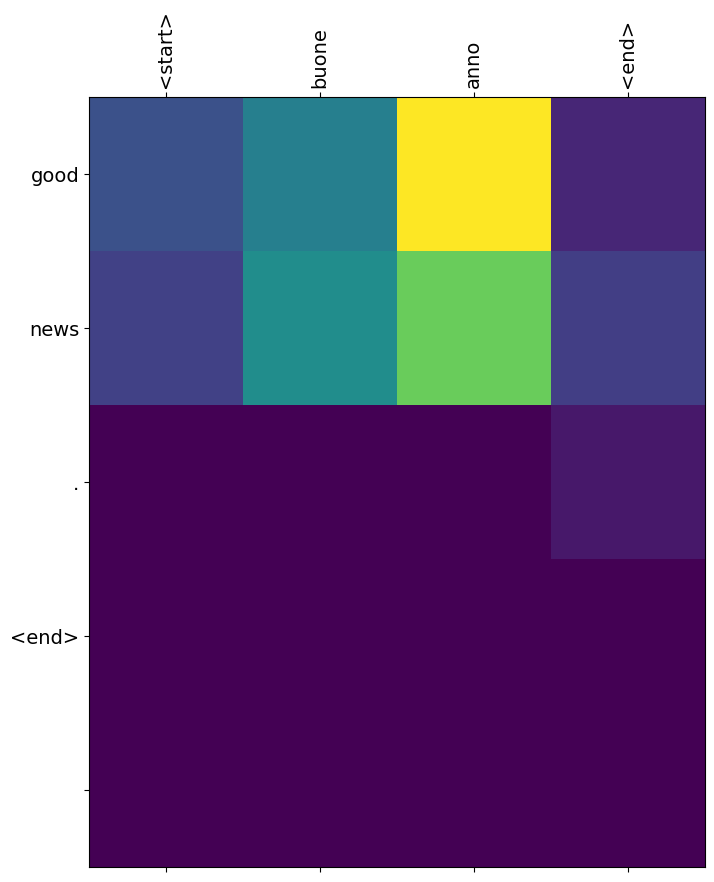

In [69]:
translate_att('buone anno')

Input: <start> lasciate mi cantare <end>
Predicted translation: let me singing . <end> 


/tmp/ipykernel_4967/956743606.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_4967/956743606.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


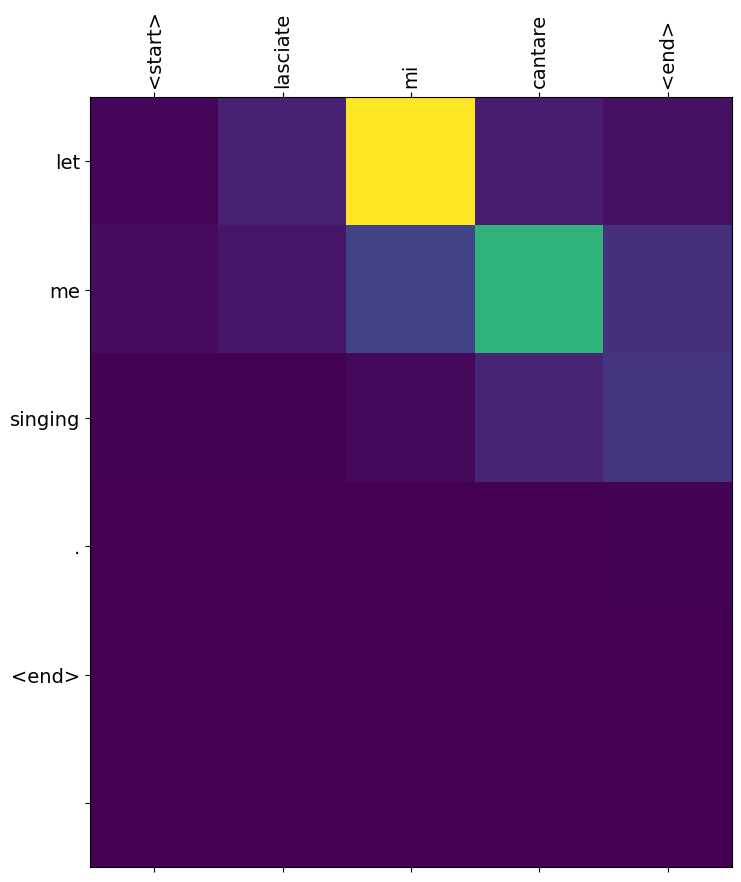

In [74]:
translate_att('lasciate mi cantare')